# Modeling M100 Lateness

Here we're trying to model the M100's lateness and simulated crowdedness in the St. Nicholas stop going to Inwood 220 St Via Amsterdam Via Bway. 

We are applying Datacamp's Decision-Tree for Classification

## Table of Contents:
1. [Data Cleaning](#data-cleaning)
1. [Plotting a Chart for Sanity](#plotting-a-chart-for-sanity)
1. [Saving our Progress](#saving-our-progress)
1. [Model Training](#model-training)\*
1. [Data Cleaning](#data-cleaning)\*

\* Not finished yet

Imports

In [280]:
%matplotlib inline

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import KFold, train_test_split

warnings.filterwarnings("ignore")
random_state = 20181112
import datetime, math, glob

Adding data from the M100 csv file.

In [281]:
%%capture
df = pd.read_csv('M100_Aug_W125_st.csv', error_bad_lines=False)

# Data Cleaning

What we need to do:  

1. Clean and break up the time components (Hour, Mins, Secs) of the following:
    * `RecordedAtTime`
    * `ExpectedArrivalTime`
    * `ScheduledArrivalTime`
    
2. Store features of interest:
    * `RecordedAtTime`
    * `VehicleLocation.Longitude`
    * `VehicleLocation.Latitude`
    * `DistanceFromStop`
    * `ExpectedArrivalTime`
   

In [282]:
df['ScheduledArrivalTime'] = pd.to_datetime(df.ScheduledArrivalTime, errors='coerce')
df.dropna()
df['Scheduled_Hour'] = df['ScheduledArrivalTime'].dt.hour
df['Scheduled_Minute'] = df['ScheduledArrivalTime'].dt.minute
df['Scheduled_Seconds'] = df['ScheduledArrivalTime'].dt.second

df['RecordedAtTime'] = pd.to_datetime(df.RecordedAtTime)
df['Recorded_Hour'] = pd.to_datetime(df.RecordedAtTime).dt.hour
df['Recorded_Minute'] = pd.to_datetime(df.RecordedAtTime).dt.minute
df['Recorded_Seconds'] = pd.to_datetime(df.RecordedAtTime).dt.second

df['ExpectedArrivalTime'] = pd.to_datetime(df.ExpectedArrivalTime)
df['Expected_Hour'] = pd.to_datetime(df.ExpectedArrivalTime).dt.hour
df['Expected_Minute'] = pd.to_datetime(df.ExpectedArrivalTime).dt.minute
df['Expected_Seconds'] = pd.to_datetime(df.ExpectedArrivalTime).dt.second

In [283]:
df.dtypes

RecordedAtTime               datetime64[ns]
DirectionRef                          int64
PublishedLineName                    object
OriginName                           object
OriginLat                           float64
OriginLong                          float64
DestinationName                      object
DestinationLat                      float64
DestinationLong                     float64
VehicleRef                           object
VehicleLocation.Latitude            float64
VehicleLocation.Longitude           float64
NextStopPointName                    object
ArrivalProximityText                 object
DistanceFromStop                    float64
ExpectedArrivalTime          datetime64[ns]
ScheduledArrivalTime         datetime64[ns]
time_diff_bus                        object
time_diff_bus_mins                    int64
Scheduled_Hour                      float64
Scheduled_Minute                    float64
Scheduled_Seconds                   float64
Recorded_Hour                   

In [284]:
df.count()

RecordedAtTime               89
DirectionRef                 89
PublishedLineName            89
OriginName                   89
OriginLat                    89
OriginLong                   89
DestinationName              89
DestinationLat               89
DestinationLong              89
VehicleRef                   89
VehicleLocation.Latitude     89
VehicleLocation.Longitude    89
NextStopPointName            89
ArrivalProximityText         89
DistanceFromStop             89
ExpectedArrivalTime          89
ScheduledArrivalTime         86
time_diff_bus                88
time_diff_bus_mins           89
Scheduled_Hour               86
Scheduled_Minute             86
Scheduled_Seconds            86
Recorded_Hour                89
Recorded_Minute              89
Recorded_Seconds             89
Expected_Hour                89
Expected_Minute              89
Expected_Seconds             89
dtype: int64

In [293]:
features = (['VehicleLocation.Longitude', 
             'VehicleLocation.Latitude', 
             'OriginLong',
             'OriginLat',
             'DistanceFromStop',
             'Recorded_Hour',
             'Recorded_Minute',
             'Recorded_Seconds',
             'time_diff_bus_mins',
             'RecordedAtTime'
            ])

model_df = df[(features)].dropna().reset_index()

model_df.count()

index                        89
VehicleLocation.Longitude    89
VehicleLocation.Latitude     89
OriginLong                   89
OriginLat                    89
DistanceFromStop             89
Recorded_Hour                89
Recorded_Minute              89
Recorded_Seconds             89
time_diff_bus_mins           89
RecordedAtTime               89
dtype: int64

# Plotting a Chart for Sanity

We want to have a frequency/histogram for each hour of the day and for each minute of the hour.

Credit: David

In [307]:
def ecdf(inputSeries, label):
    try:
        x = np.sort(inputSeries)
    except:
        print("Warning: Series Unsorted")
        x = inputSeries
    y = np.arange(1, len(x)+1) / len(x)
    _ = plt.plot(x, y, marker='.', linestyle='none')
    _ = plt.xlabel('Time Delta ({})'.format(label))
    _ = plt.ylabel('ECDF')
    plt.margins(0.02) # Keeps data off plot edges
    plt.show()
    
def hist(inputSeries, label):
    plt.hist(inputSeries, bins=25, density=True)
    _ = plt.xlabel('Time Delta ({})'.format(label))
    _ = plt.ylabel('PDF')
    plt.show()

In [308]:
M100_NICK_Avg = model_df[['Recorded_Hour','time_diff_bus_mins', 'Recorded_Minute']]
M100_Hour = M100_NICK_Avg.groupby('Recorded_Hour').mean().dropna()
M100_Min = M100_NICK_Avg.groupby('Recorded_Minute').mean().dropna()
M100_NICK_Avg.head()

,Recorded_Hour,time_diff_bus_mins,Recorded_Minute
0,7,0,51
1,7,0,51
2,7,0,51
3,11,191,2
4,13,161,42


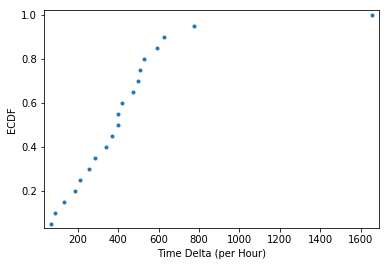

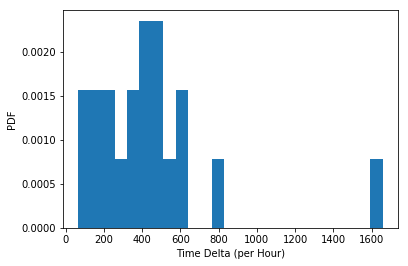

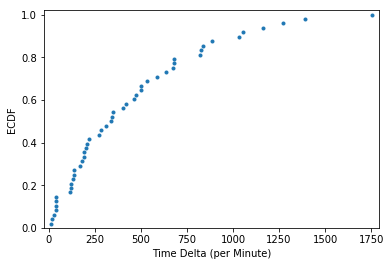

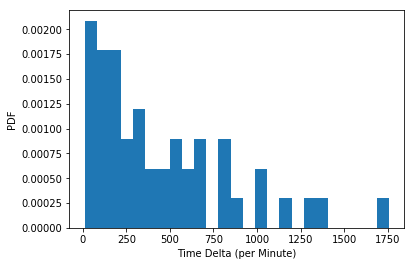

In [309]:
ecdf(M100_Hour['time_diff_bus_mins'], "per Hour")
hist(M100_Hour['time_diff_bus_mins'], "per Hour")

ecdf(M100_Min['time_diff_bus_mins'], "per Minute")
hist(M100_Min['time_diff_bus_mins'], "per Minute")

# Saving our Progress

In [310]:
model_df.to_csv('M100_4_month_W125_st_timesplit.csv', encoding='utf-8', index=False)

Splitting training and testing datasets

In [271]:
train_df, holdout_df, y_train, y_holdout = train_test_split(model_df[features],
                                                    model_df['ON_TIME'],
                                                    test_size=0.3,
                                                    random_state=42)

train_df['success'] = y_train
holdout_df['success'] = y_holdout

train_df.reset_index(inplace=True)
holdout_df.reset_index(inplace=True)

print(train_df.shape[0], train_df.success.mean())
print(holdout_df.shape[0], holdout_df.success.mean())

206 0.043689320388349516
89 0.0449438202247191


# Model Training

Let's take a quick look at all of our classification model options using cross validation. For the tree based models, we'll use the hyperparameter `max_depth=6` as a naive attempt at voiding overfitting before we dig deeper.

Let's fit and score the model, this time using cross validation:

In [272]:
k_fold = KFold(n_splits=5, random_state=random_state)

In [273]:
def get_cv_results(classifier):
    
    results = []
    for train, test in k_fold.split(train_df):
        classifier.fit(train_df.loc[train, features], train_df.loc[train, 'success'])
        y_predicted = classifier.predict(train_df.loc[test, features])
        accuracy = accuracy_score(train_df.loc[test, 'success'], y_predicted)
        results.append(accuracy)
    
    return np.mean(results), np.std(results)


Logistic Regression

In [274]:
logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)

get_cv_results(logreg)

(0.95632984901277585, 0.018195731500642152)

Decision Tree

In [275]:
dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=6
)

get_cv_results(dtree)

(0.91242740998838556, 0.068426867313183329)

Random Forest

In [276]:
rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)

get_cv_results(rforest)

(0.94169570267131242, 0.033156218663414776)

Gradient Boosting Machines

In [277]:
gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)

get_cv_results(gbm)

(0.91242740998838556, 0.066665452606637352)

# Evaluating Model Performance

We're using ROC curves to visually see which model performs the best.

In [278]:
def plot_roc(classifier, label, color):

    classifier.fit(train_df[features], train_df['success'])
    y_prob = classifier.predict_proba(holdout_df[features])
    
    fpr, tpr, thresh = roc_curve(holdout_df['success'], y_prob[:,1])
    plt.plot(fpr, tpr,
             label=label,
             color=color, linewidth=3)

    auc = roc_auc_score(holdout_df['success'], y_prob[:,1])
    
    print('AUC: %0.3f (%s)' % (auc, label))

AUC: 0.888 (Logistic Regression)
AUC: 0.756 (Decision Tree)
AUC: 0.850 (Random Forest)
AUC: 0.862 (GBM)


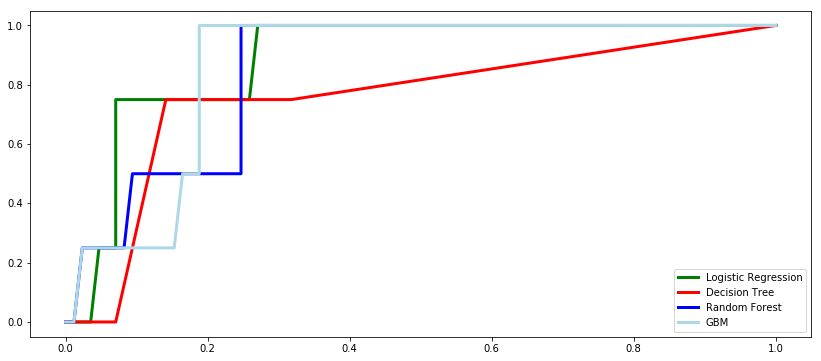

In [279]:
f1 = plt.figure(figsize=(14,6))

logreg = LogisticRegression(
    random_state=random_state, 
    solver='lbfgs'
)
plot_roc(logreg, 'Logistic Regression', 'green')

dtree = DecisionTreeClassifier(
    random_state=random_state, 
    max_depth=3
)
plot_roc(dtree, 'Decision Tree', 'red')

rforest = RandomForestClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)
plot_roc(rforest, 'Random Forest', 'blue')

gbm = GradientBoostingClassifier(
    random_state=random_state, 
    max_depth=6,
    n_estimators=100
)
plot_roc(gbm, 'GBM', 'lightblue')

plt.legend(loc='lower right')